# Mapping

This notebook uses the cartopy package to generate maps of the data variables of interest across the Arctic Ocean. It uses data contained in the xarray file generated in the [data wrangling](https://nicolejkeeney.github.io/icesat2-book/data_wrangling.html) notebook with all data provided on the same Polar Stereographic grid to simplify the analysis/mapping.

**Input**:
- xarray dataset from the Jupyter Book's google bucket
 
 
**Output**: 
- maps of the Arctic with data overlayed

```{tip}
Try running this notebook in Google Colab! Toggle over the rocketship icon at the top of the page and click Colab to open a new window and run the notebook. <br><br>To run a single cell, type **Shift+Enter**. To run the whole notebook, under **Runtime** click **Run all**. Note that you will have to run the notebook from the very beginning and load all the Google Colab dependencies for the code to work.
```

In [1]:
#this cell will load dependencies for running the notebook in Google Colab
#this cell may take a while to run
import sys

#if code is running in google colab, run these cells to install neccessary libraries
if 'google.colab' in sys.modules: 
    !apt-get install -qq libgdal-dev libproj-dev
    !pip install --no-binary shapely shapely --force
    !pip install -q pyproj
    !pip install cartopy
    !pip install netcdf4
    !pip install xarray==0.16.0

# Import notebook dependencies

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
from textwrap import wrap

#axes needed for plotting
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

#remove warnings to improve display
import warnings
warnings.filterwarnings('ignore')

#increase resolution for notebook outputs
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

# Load data into notebook
Copy file from the book's google bucket and load into an xarray dataset. 

In [3]:
!gsutil -m cp gs://sea-ice-thickness-data/xarray/icesat2-book-data.nc ./
dataset = xr.open_dataset('icesat2-book-data.nc')

If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Copying gs://sea-ice-thickness-data/xarray/icesat2-book-data.nc...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1/1 files][157.1 MiB/157.1 MiB] 100% Done  14.6 MiB/s ETA 00:00:00           
Operation completed over 1 objects/157.1 MiB.                                    


# Plot one month of data 
Visualize one month of data on a map of the arctic

In [4]:
def plotOneMonth(dataset, dataVar, month, minval, maxval, cbarTicks = None, cmap = 'viridis', figPath = None): 
    """Plots map of the arctic on North Pole Stereo projection with one month of data overlayed, along with the sea ice edge for each month.
    Cartopy has a bug and cannot produce a contour plot on a rotated grid. Here we use a workaround from stackexchange: https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
   
    Args:
        dataset (xr Dataset): dataset from google bucket
        dataVar (str): variable of interest
        month (str): month and year of interest, i.e. 'Dec 2019' (does not need to be in any particular format)
        minval, maxval (int): minimum and maximum values for the data variable 
        cbarTicks (list or np array of length 2): ticks to use on colorbar (default to [minval + 1, maxval +1])
        cmap (str, optional): color map (default to viridis)
        figPath (str, optional): path to save fig (default to None)
        
    Returns:
        Figure displayed in notebook 
    
    """
    
    #define projection and transform
    proj = ccrs.NorthPolarStereo(central_longitude = -45)
    transform = ccrs.PlateCarree()
    
    #initialize the figure and axes 
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection = proj)
    
    #define arguments if not inputted 
    cbarTicks = np.arange(minval, maxval + 1, 1) if cbarTicks is None else cbarTicks
    
    #plot sea ice concentraion 
    SICarray = dataset['seaice_conc_monthly_cdr'].sel(time = month).where(dataset['region_mask']!=21) #dont plot contour along coastlines
    
    #stackexchange workaround for plotting on a rotated grid
    lonGreater = ma.masked_greater(SICarray.longitude.values, -0.01)
    lonLesser = ma.masked_less(SICarray.longitude.values, 0)
    latGreater = ma.MaskedArray(SICarray.latitude.values, mask = lonGreater.mask)
    latLesser = ma.MaskedArray(SICarray.latitude.values, mask = lonLesser.mask)
    dataGreater = ma.MaskedArray(SICarray.values[0], mask = lonGreater.mask)
    dataLesser = ma.MaskedArray(SICarray.values[0], mask = lonLesser.mask)
    
    #plot contour using each part of the 2 masked data sets
    im2a = ax.contour(lonGreater, latGreater, dataGreater, levels = [0.5], transform = transform, colors = 'magenta', linewidths = 0.9, zorder=5, alpha=1)
    im2b = ax.contour(lonLesser, latLesser, dataLesser, levels = [0.5], transform = transform, colors = 'magenta', linewidths = 0.9, zorder=5, alpha=1)
    #im = ax.contour(SICarray.longitude.values, SICarray.latitude.values, SICarray.values[0], levels = [0.15], transform = transform, colors = 'magenta', linewidths = 0.8, zorder=15, alpha=1)
    
    #create colorbar label using variable name and units if available as attributes
    cbar_label = ""
    if 'long_name' in dataset[dataVar].attrs:
        cbar_label += dataset[dataVar].attrs['long_name'] + " "
    if 'units' in dataset[dataVar].attrs:
        cbar_label += "(" + dataset[dataVar].attrs['units'] + ")"
    elif 'unit' in dataset[dataVar].attrs: 
        cbar_label += "(" + dataset[dataVar].attrs['unit'] + ")"

    #plot the data
    dataset[dataVar].where(dataset['seaice_conc_monthly_cdr'] > 0.5).sel(time = month).plot(x = 'longitude', y = 'latitude', vmin = minval, vmax = maxval, extend = 'both', 
                     ax = ax, add_colorbar = True, transform = transform, zorder = 2, cmap = cmap, 
                     cbar_kwargs = {'label': "\n".join(wrap(cbar_label, 50)), 'orientation': 'horizontal', 'shrink': 0.75, 'pad': 0.025})
    
    #add features to the map
    ax.coastlines(linewidth=0.15, color = 'black', zorder = 10) #add coastlines 
    ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5) #add land 
    ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5) #add lakes 
    ax.gridlines(draw_labels = False, linewidth = 0.25, color = 'gray', alpha = 0.7, linestyle = '--', zorder = 6) #add gridlines
    ax.set_extent([-179, 179, 55, 90], crs = transform) #zoom in so map only displays the Arctic
    ax.set_title("\n".join(wrap(month + ": " + dataset[dataVar].attrs['long_name'], 38)), fontsize = 'x-large')
    
    #save figure
    if figPath != None:
        plt.savefig(figPath, dpi = 200)
        
    #display figure
    plt.show()

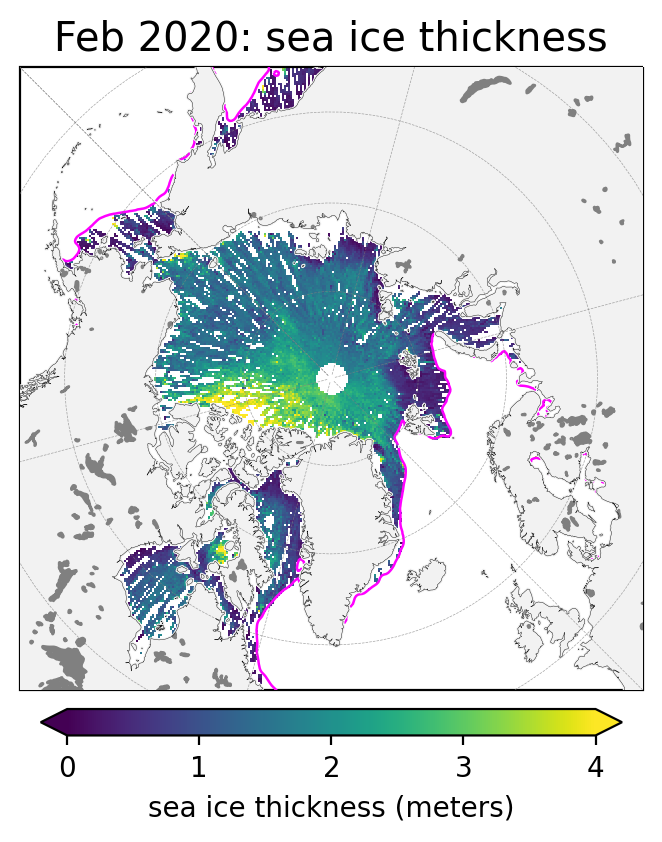

In [5]:
plotOneMonth(dataset, dataVar = 'ice_thickness', month = 'Feb 2020', minval = 0, maxval = 4)

# Restrict data to the Inner Arctic

- Here, we use the <span style="color:darkmagenta; font-family: Courier">restrictRegionally</span> function introduced in the [regional analysis](https://nicolejkeeney.github.io/icesat2-book/regional_analysis.html) notebook to remove data outside of this region.
- The Inner Arctic is defined as the combined area of the Central Arctic, Beaufort Sea, Chukchi Sea, E Siberian Sea and the Laptev Sea. Figure from Petty et al., (2020): <br>

<img src='figs/inner_arctic_petty2020.png' width=350 height=350 align='left' />

In [6]:
#function from regional_analysis notebook
def restrictRegionally(dataset, regionKeyList): 
    """Restrict dataset to input regions.
    
    Args: 
        dataset (xr Dataset): dataset generated by Load_IS2 notebook
        regionKeyList (list): list of region keys to restrict data to 
        
    Returns: 
        regionalDataset (xr Dataset): dataset with restricted data to input regions
    """
    
    def checkKeys(regionKeyList, regionTbl): 
        """Check that regionKeyList was defined correctly

        Raises: 
            ValueError if regionKeyList was not defined correctly 
            warning if all data was removed from the dataset
        """
        if type(regionKeyList) != list: #raise a ValueError if regionKeyList is not a list 
            raise ValueError('regionKeyList needs to be a list. \nFor example, if you want to restrict data to the Beaufort Sea, define regionKeyList = [13]')

        for key in regionKeyList: 
            if key not in list(regionTbl['key']): 
                raise ValueError('Region key ' + str(key) + ' does not exist in region mask. \n Redefine regionKeyList with key numbers from table')

        if len(regionKeyList) == 0: 
            warnings.warn('You removed all the data from the dataset. Are you sure you wanted to do this? \n If not, make sure the list regionKeyList is not empty and try again. \n If you intended to keep data from all regions, set regionKeyList = list(tbl[\"key\"])')
 
    #create a table of keys and labels
    regionMask = dataset.region_mask.attrs
    regionTbl = pd.DataFrame({'key': regionMask['keys'], 'label': regionMask['labels']})
    
    #call function to check if regionKeyList was defined correctly
    checkKeys(regionKeyList, regionTbl)
    
    #keys to remove (all keys that are note listed in regionKeyList)
    keysToRemove = [key for key in list(regionTbl['key']) if key not in regionKeyList]
    
    #filter elements from the ice thickness DataArray where the region is the desired region
    regionalDataset = dataset.copy()
    for var in dataset.data_vars: 
        if var != 'seaice_conc_monthly_cdr':
            regionalVar = regionalDataset[var]
            for key in keysToRemove: 
                regionalVar = regionalVar.where(regionalVar['region_mask'] != key)
            regionalDataset[var] = regionalVar
    
    #find name of labels 
    labels = [regionTbl[regionTbl['key'] == key]['label'].item() for key in regionKeyList]
    
    #add new attributes describing changes made to the dataset
    if len(labels) < len(regionTbl['key']): 
        if set(regionKeyList) == set([10,11,12,13,15]): #convert to sets so unordered lists are compared
            regionalDataset.attrs['regions with data'] = 'Inner Arctic'
        else:    
            regionalDataset.attrs['regions with data'] = ('%s' % ', '.join(map(str, labels)))
        print('Regions selected: ' + regionalDataset.attrs['regions with data'])
    else: 
        regionalDataset.attrs['regions with data'] = 'All'
        print('Regions selected: All \nNo regions will be removed')
    
    return regionalDataset

Regions selected: Inner Arctic


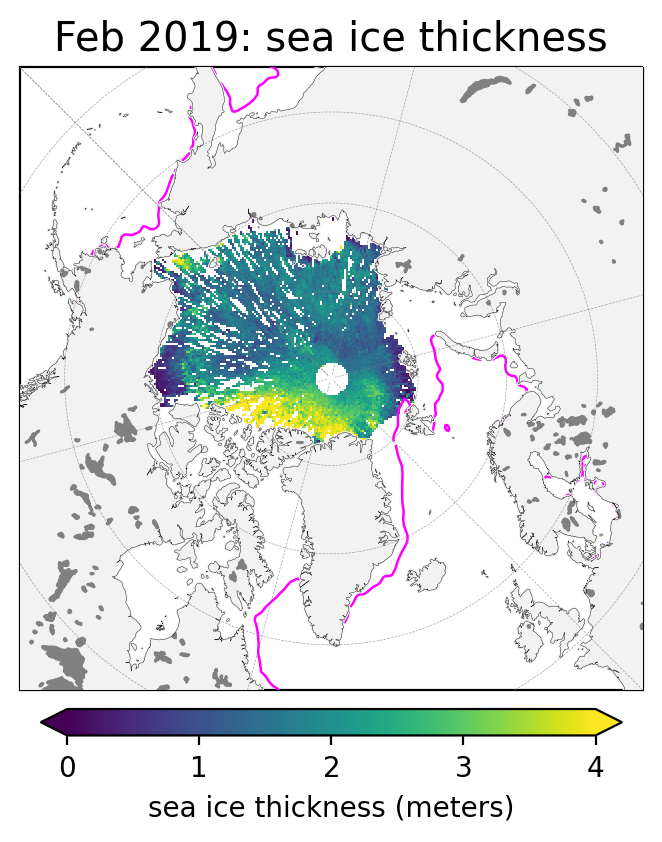

In [7]:
#define a list of keys corresponding to the region of interest
regionKeyList = [10,11,12,13,15] #Inner Arctic

#restrict data to that region
regionalDataset = restrictRegionally(dataset, regionKeyList)

#plot regional data
plotOneMonth(regionalDataset, dataVar = 'ice_thickness', month = 'Feb 2019', minval = 0, maxval  = 4)

# Compute mean gridcell values over time dimension
Here we compute the mean monthly value for each grid cell over the two winter seasons of interest, giving us a new xarray dataset with 6 time values corresponding to Nov, Dec, Jan, Feb, Mar, and Apr. 

In [8]:
# Get both winter seasons. Combine to form one dataset
winter_2018_19 = dataset.sel(time = slice('Nov 2018', 'Apr 2019')) # Winter 2018-2019
winter_2019_20 = dataset.sel(time = slice('Nov 2019', 'Apr 2020')) # Winter 2019-2020
winter_2018_20 = xr.merge([winter_2018_19, winter_2019_20]) # Both winters: Nov 2018-Apr 2019, Nov 2019-Apr 2020

# Compute gridcell mean values over time dimension 
winter_mean = winter_2018_20.groupby('time.month').mean('time')
winter_mean = winter_mean.rename({'month':'time'}) # Change to time to match plotting function

# Carry forward variable attributes
for var in winter_mean.data_vars: 
    winter_mean[var] = winter_mean[var].assign_attrs(dataset[var].attrs)

# Assign string values to represent months 
mon_dict = {1:"Jan",2:"Feb",3:"Mar",4:'Apr',11:'Nov',12:'Dec'}
winter_mean['time'] = [mon_dict[int_mon] for int_mon in winter_mean.time.values]
winter_mean['time'] = winter_mean['time'].assign_attrs({'long_name':'winter 2018-2019 mean values'})

# Plot mean winter data 
- Plot mean monthly data for the winter 2019 and 2020 for the Inner Arctic region defined above 
- This plotting function is modified from the plotOneMonth function (see above) to plot 6 months of data instead of one

In [9]:
def plotWinterMaps(dataset, dataVar, minval, maxval, cbarTicks = None, title = "", cmap = 'viridis', figPath = None):
    """Plot maps of the arctic on North Pole Stereo projection with several months of data overlayed, along with the sea ice edge for each month. 
   
    Args:
        dataset (xr Dataset): dataset from google bucket
        dataVar (str): variable of interest
        minval, maxval (int): minimum and maximum values for the data variable 
        cbarTicks (list or np array of length 2): ticks to use on colorbar (default to [minval + 1, maxval +1])
        title (str, optional): title of subplots (default to empty string)
        cmap (str, optional): color map (default to viridis)
        figPath (str, optional): path to save fig (default to None)
        
    Returns:
        Figure displayed in notebook 

    """
    #define projection and transform
    proj = ccrs.NorthPolarStereo(central_longitude = -45)
    transform = ccrs.PlateCarree()
    
    #initialize figure and axes
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7.8, 5.8), subplot_kw={'projection': proj})
    
    for i in range(len(dataset.time)):
        ax = axs.flatten()[i]
        
        #plot data 
        im = dataset[dataVar].where(dataset['seaice_conc_monthly_cdr'] > 0.5).isel(time = i).plot(x = 'longitude', y = 'latitude', vmin = minval, vmax = maxval, extend = 'both', 
                    ax = ax, add_colorbar = False, transform = transform, zorder = 2, cmap = cmap)
    
        #plot sea ice concentration 
        SICarray = dataset['seaice_conc_monthly_cdr'].where(dataset['region_mask']!=21).isel(time = i) #dont plot contour along coastlines
        lonGreater = ma.masked_greater(SICarray.longitude.values, -0.01)
        lonLesser = ma.masked_less(SICarray.longitude.values, 0)
        latGreater = ma.MaskedArray(SICarray.latitude.values, mask = lonGreater.mask)
        latLesser = ma.MaskedArray(SICarray.latitude.values, mask = lonLesser.mask)
        dataGreater = ma.MaskedArray(SICarray.values, mask = lonGreater.mask)
        dataLesser = ma.MaskedArray(SICarray.values, mask = lonLesser.mask)
        im2a = ax.contour(lonGreater, latGreater, dataGreater, levels = [0.5], transform = transform, colors = 'magenta', linewidths = 0.8, zorder = 5, alpha = 1)
        im2b = ax.contour(lonLesser, latLesser, dataLesser, levels = [0.5], transform = transform, colors = 'magenta', linewidths = 0.8, zorder = 5, alpha = 1)
        
        #add features to map
        ax.coastlines(linewidth=0.25, color = 'black', zorder = 10) #add coastlines 
        ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5) #add land 
        ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5) #add lakes 
        ax.gridlines(draw_labels = False, linewidth = 0.25, color = 'gray', alpha = 0.75, linestyle='--', zorder = 6) #add gridlines
        ax.set_extent([-179, 179, 50, 90], crs = transform) #zoom in so map only displays the Arctic
    
    #create colorbar label using variable name and units if available as attributes
    cbar_label = ""
    if 'long_name' in dataset[dataVar].attrs:
        cbar_label += dataset[dataVar].attrs['long_name'] + " "
    if 'units' in dataset[dataVar].attrs:
        cbar_label += "(" + dataset[dataVar].attrs['units'] + ")"
    elif 'unit' in dataset[dataVar].attrs: 
        cbar_label += "(" + dataset[dataVar].attrs['unit'] + ")"
    
    #add colorbar
    cax = fig.add_axes([0.27, 0, 0.5, 0.025])
    cb = fig.colorbar(im,cax = cax,extend='both',orientation = 'horizontal')
    cbarTicks = np.arange(minval, maxval + 1, 1) if cbarTicks is None else cbarTicks
    cb.set_ticks(cbarTicks)
    cb.set_label("\n".join(wrap(cbar_label, 50)), fontsize = 10)

    #additional formatting 
    fig.subplots_adjust(bottom=0.1, top=0.9, wspace=0.05, hspace=0.13)
    plt.suptitle("\n".join(wrap(title + ': ' + dataset[dataVar].attrs['long_name'], 60)), fontsize = 15, y = 0.98, fontweight = 'medium')
    plt.tight_layout()
    
    #save figure
    if figPath != None:
        plt.savefig(figPath, dpi = 200)
    
    #display figure
    plt.show()

## ICESat-2 sea ice thickness

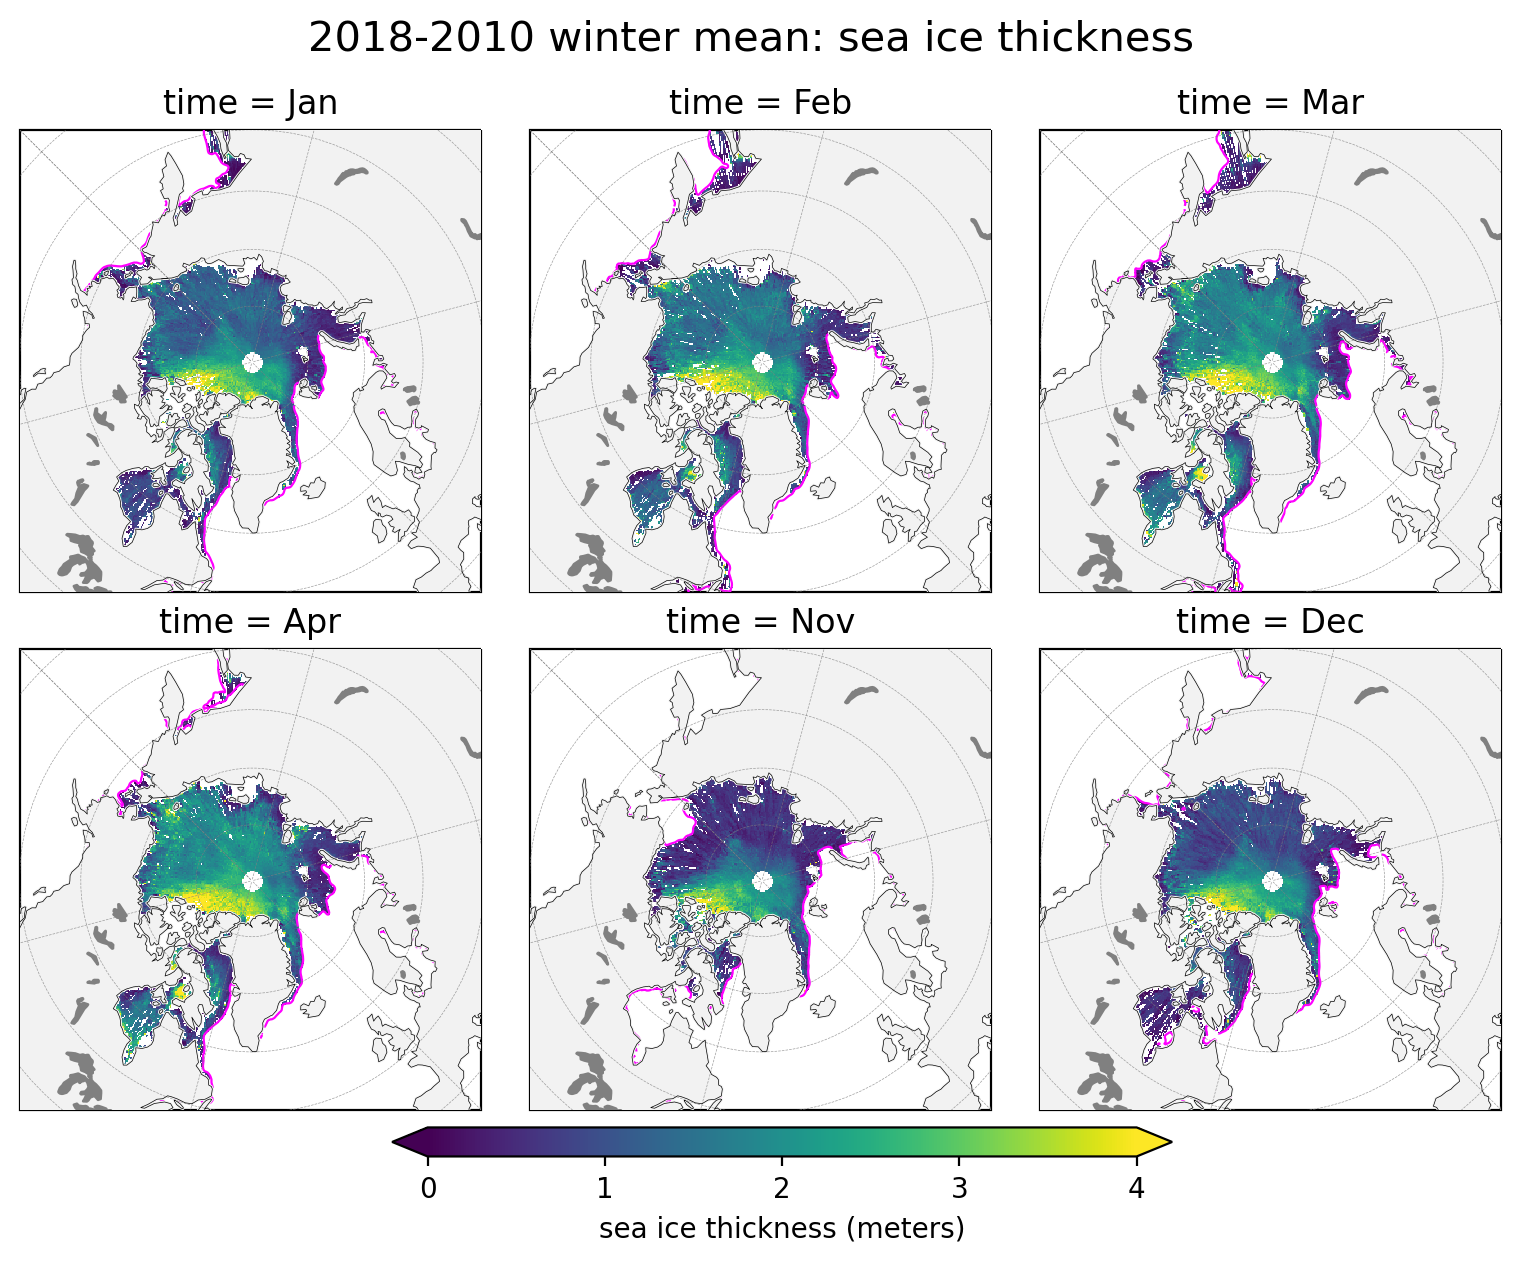

In [10]:
plotWinterMaps(winter_mean, 
               dataVar = 'ice_thickness', 
               minval = 0, maxval = 4, 
               title = '2018-2010 winter mean')

## PIOMAS sea ice thickness 

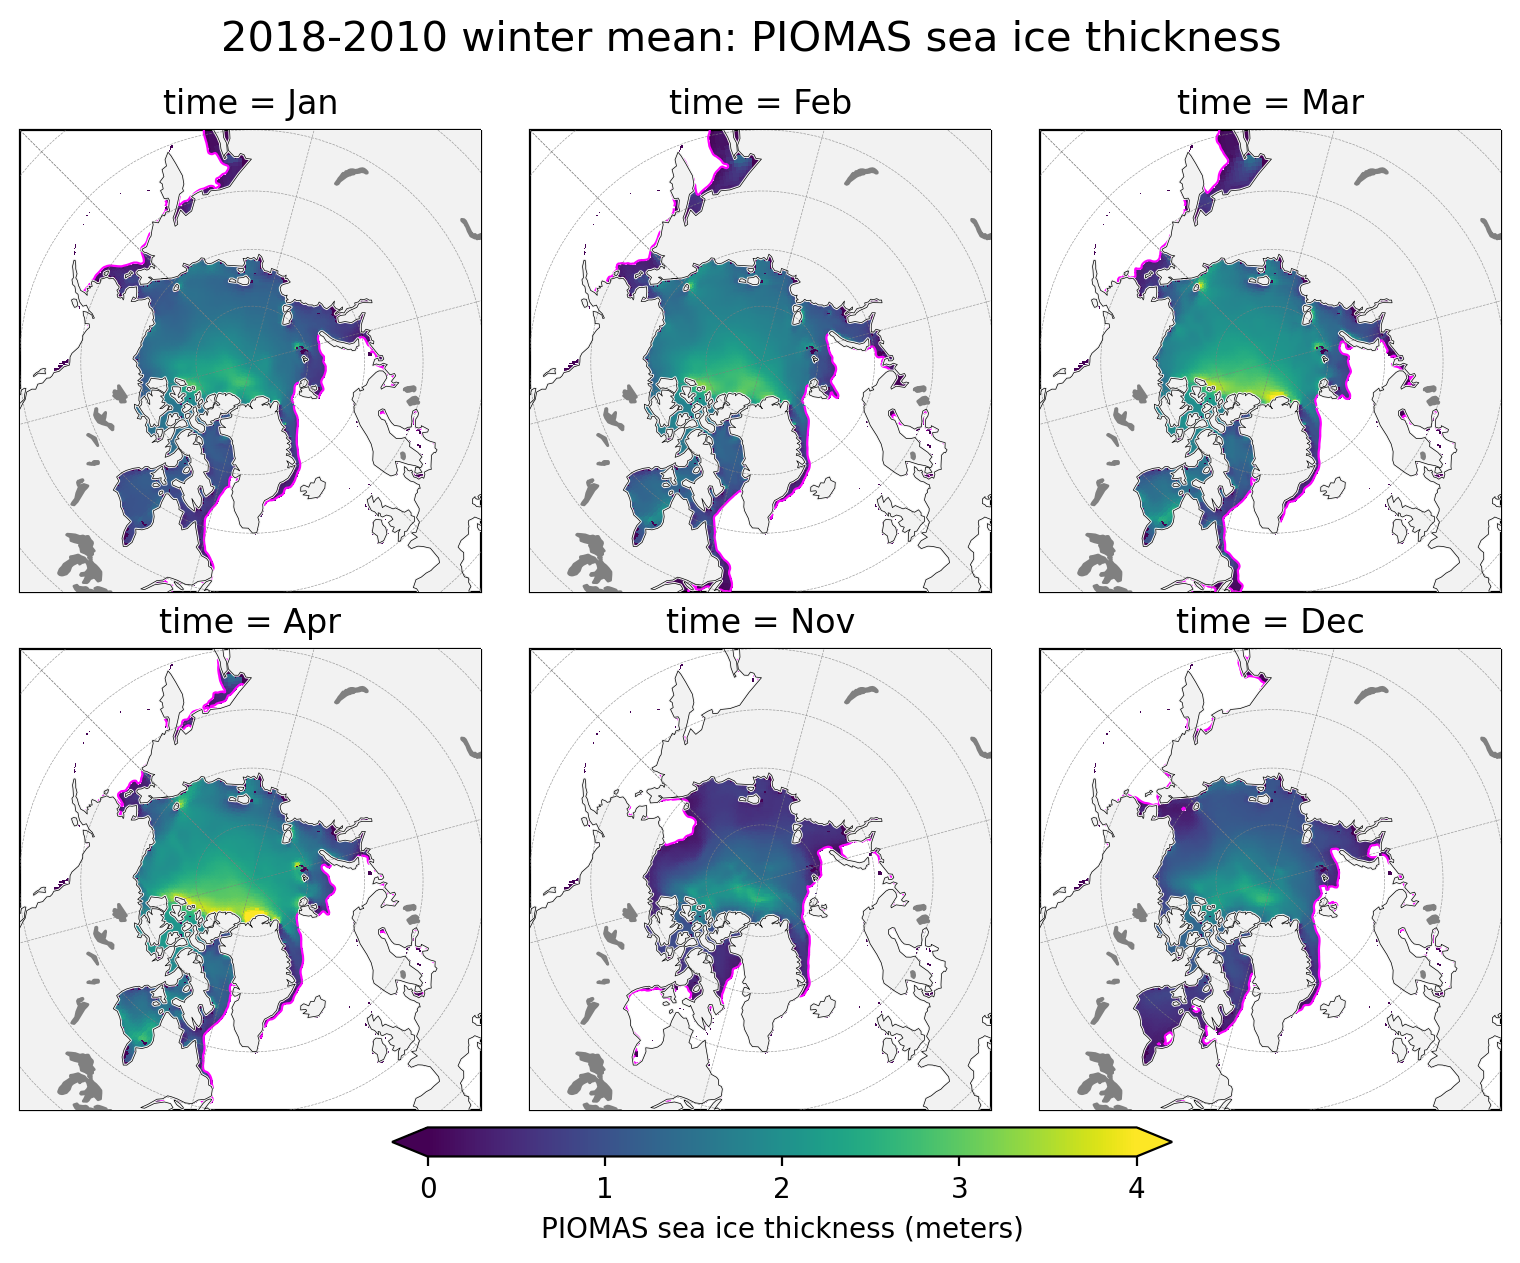

In [11]:
plotWinterMaps(winter_mean, 
               dataVar = 'PIOMAS_ice_thickness', 
               minval = 0, maxval = 4, 
               title = '2018-2010 winter mean')

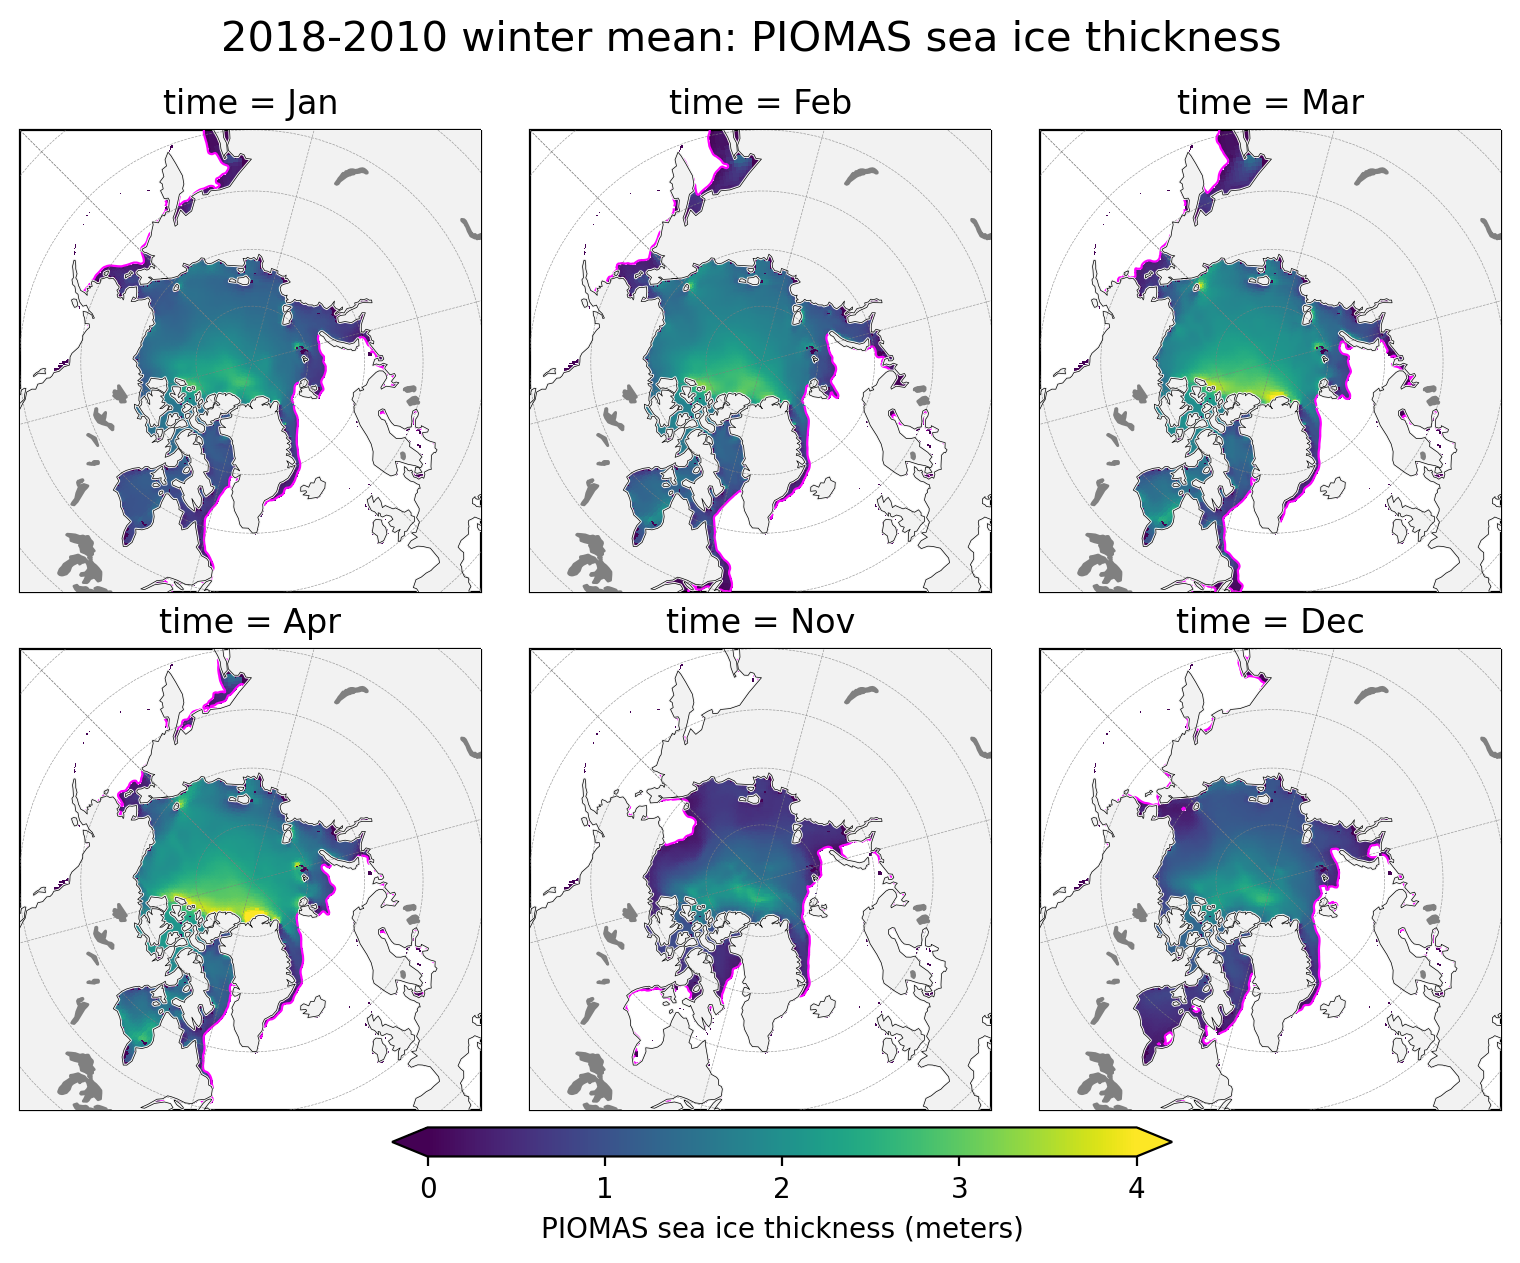

In [12]:
plotWinterMaps(winter_mean, 
               dataVar = 'PIOMAS_ice_thickness', 
               minval = 0, maxval = 4, 
               title = '2018-2010 winter mean')

## ICESat-2 sea ice thickness uncertainty

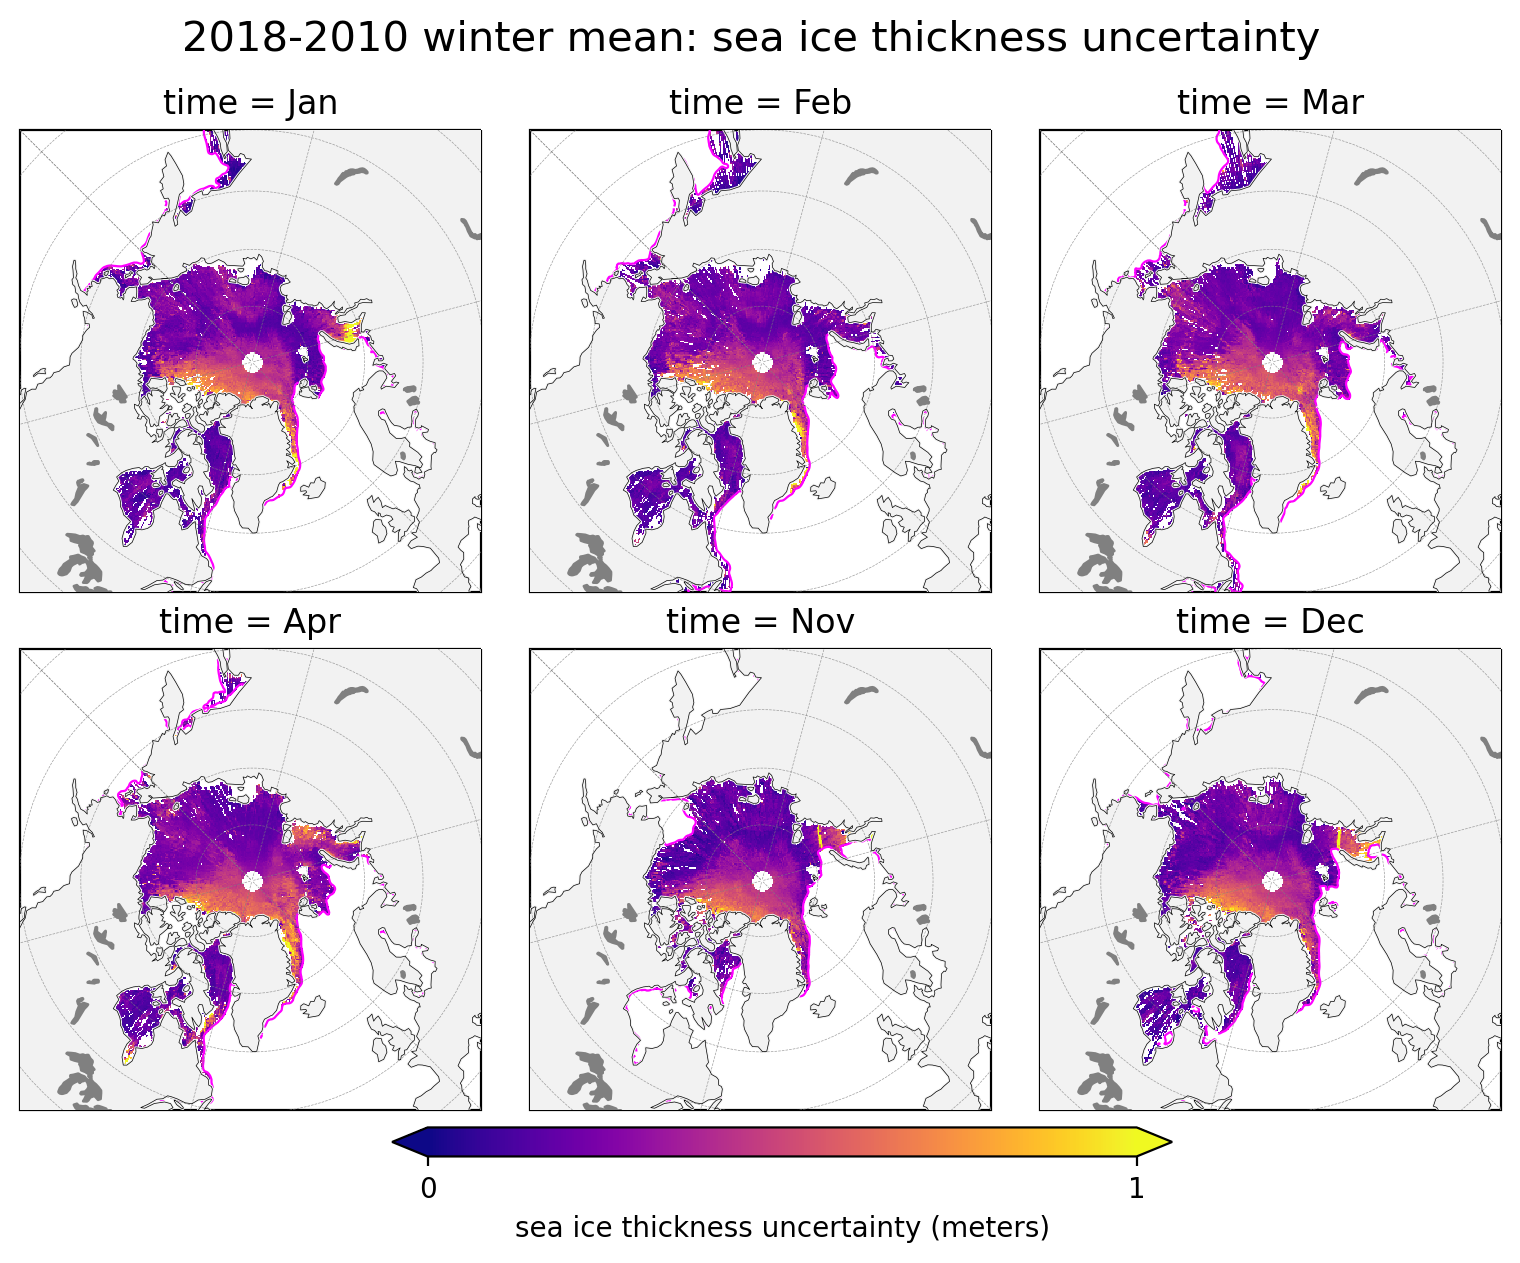

In [13]:
plotWinterMaps(winter_mean, 
               dataVar = 'ice_thickness_unc', 
               minval = 0, maxval = 1,
               cmap = 'plasma',
               title = '2018-2010 winter mean')

## OSI-SAF ice type
Ice type is categorized as a binary value of first year ice (0) or multi-year ice (1). Because we are plotting mean ice type over two winter seasons, an ice type value of 0.5 indicates a change in ice type between the two years; i.e. one winter had multi-year ice in that grid cell, and another winter had first year ice in the same grid cell. 

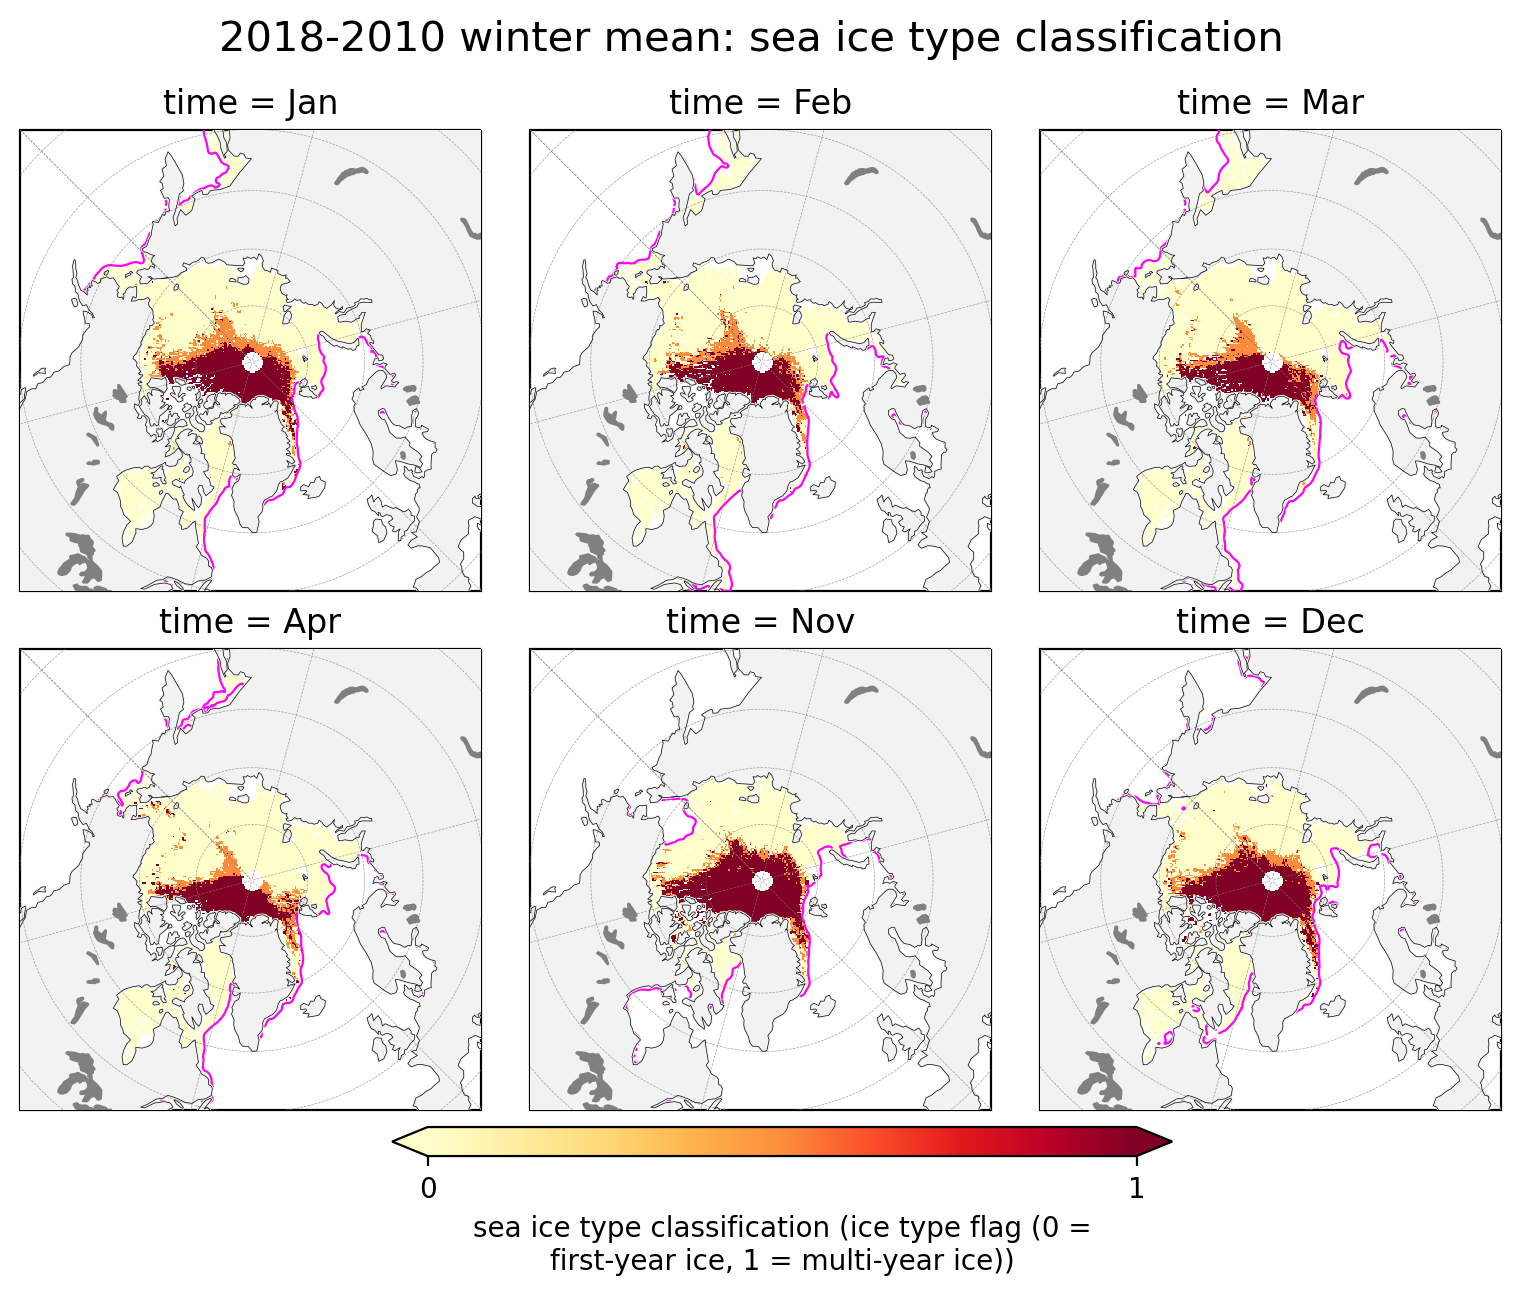

In [14]:
plotWinterMaps(winter_mean, 
               dataVar = 'ice_type', 
               minval = 0, maxval = 1,
               cmap = 'YlOrRd',
               title = '2018-2010 winter mean')

## ERA5 2-meter temperature 

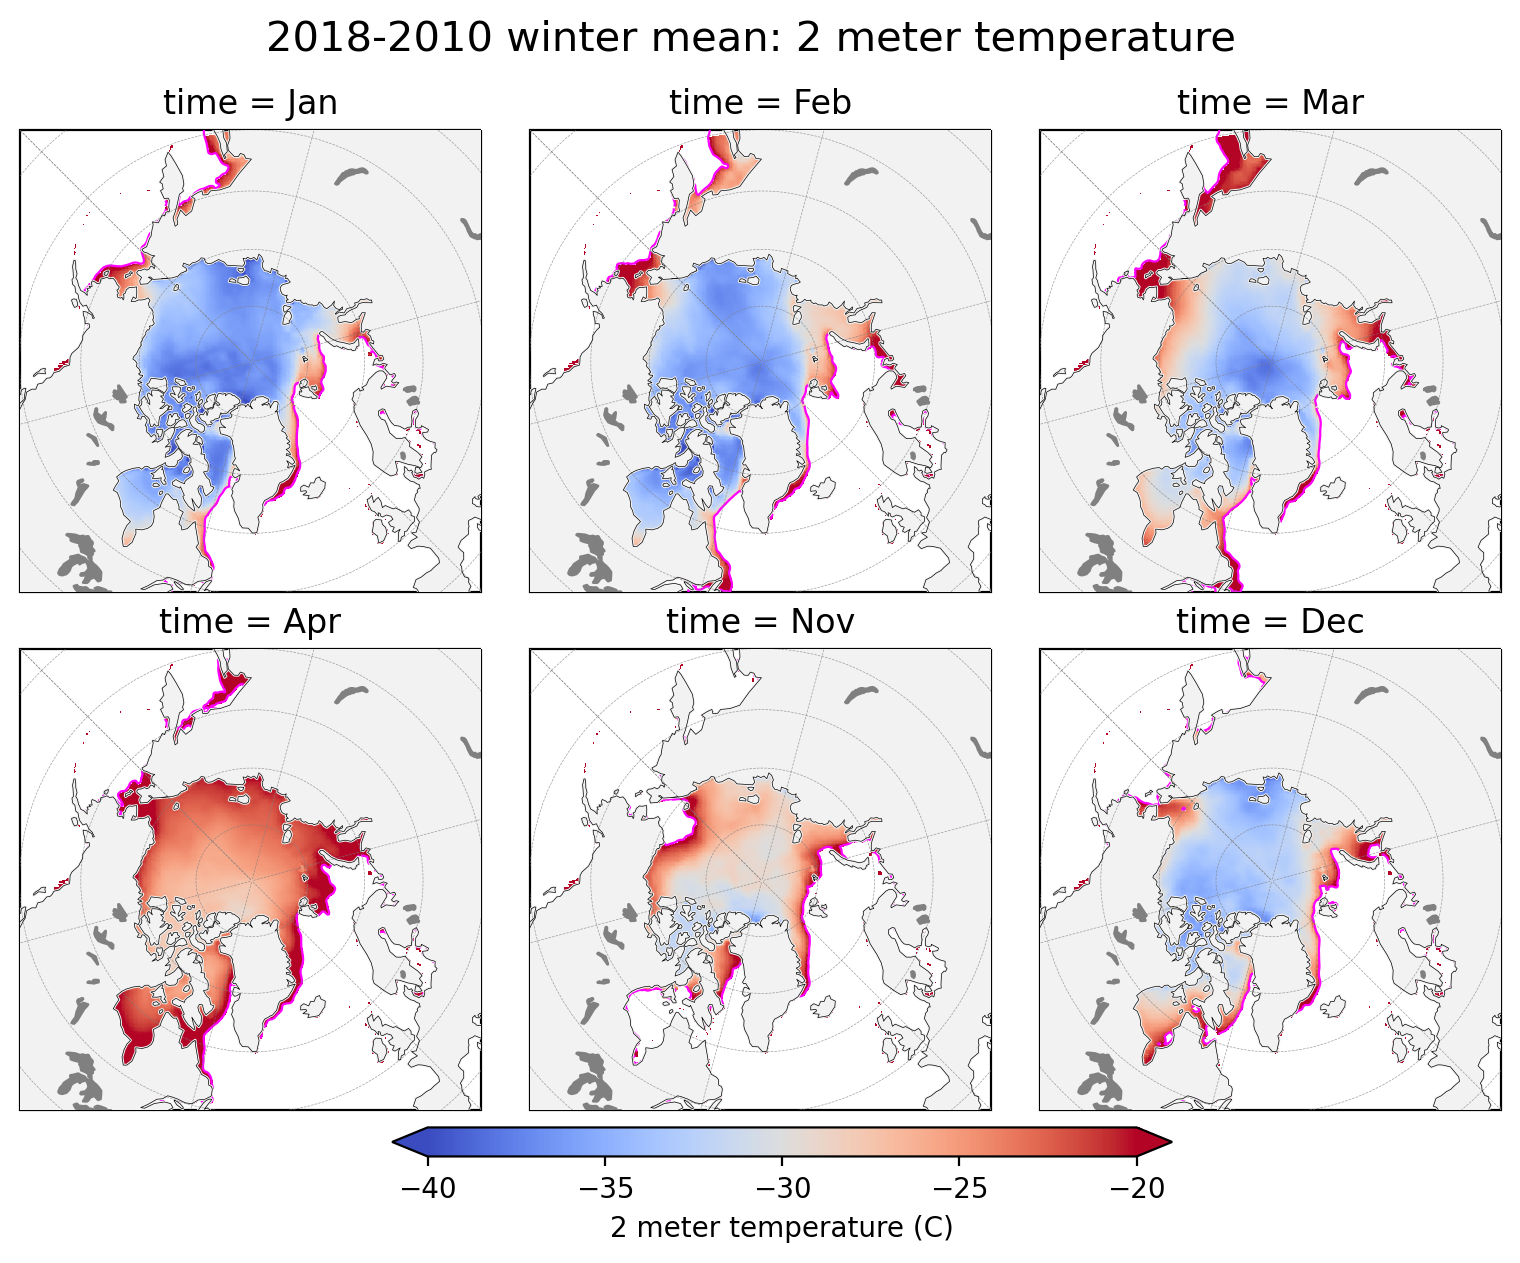

In [15]:
plotWinterMaps(winter_mean, 
               dataVar = 't2m', 
               minval = -40, maxval = -20,
               cbarTicks = np.arange(-40,-20+5,5), # Set colorbar ticks for better formatting
               cmap = 'coolwarm',
               title = '2018-2010 winter mean')

## ERA5 mean surface downward long-wave radiation flux

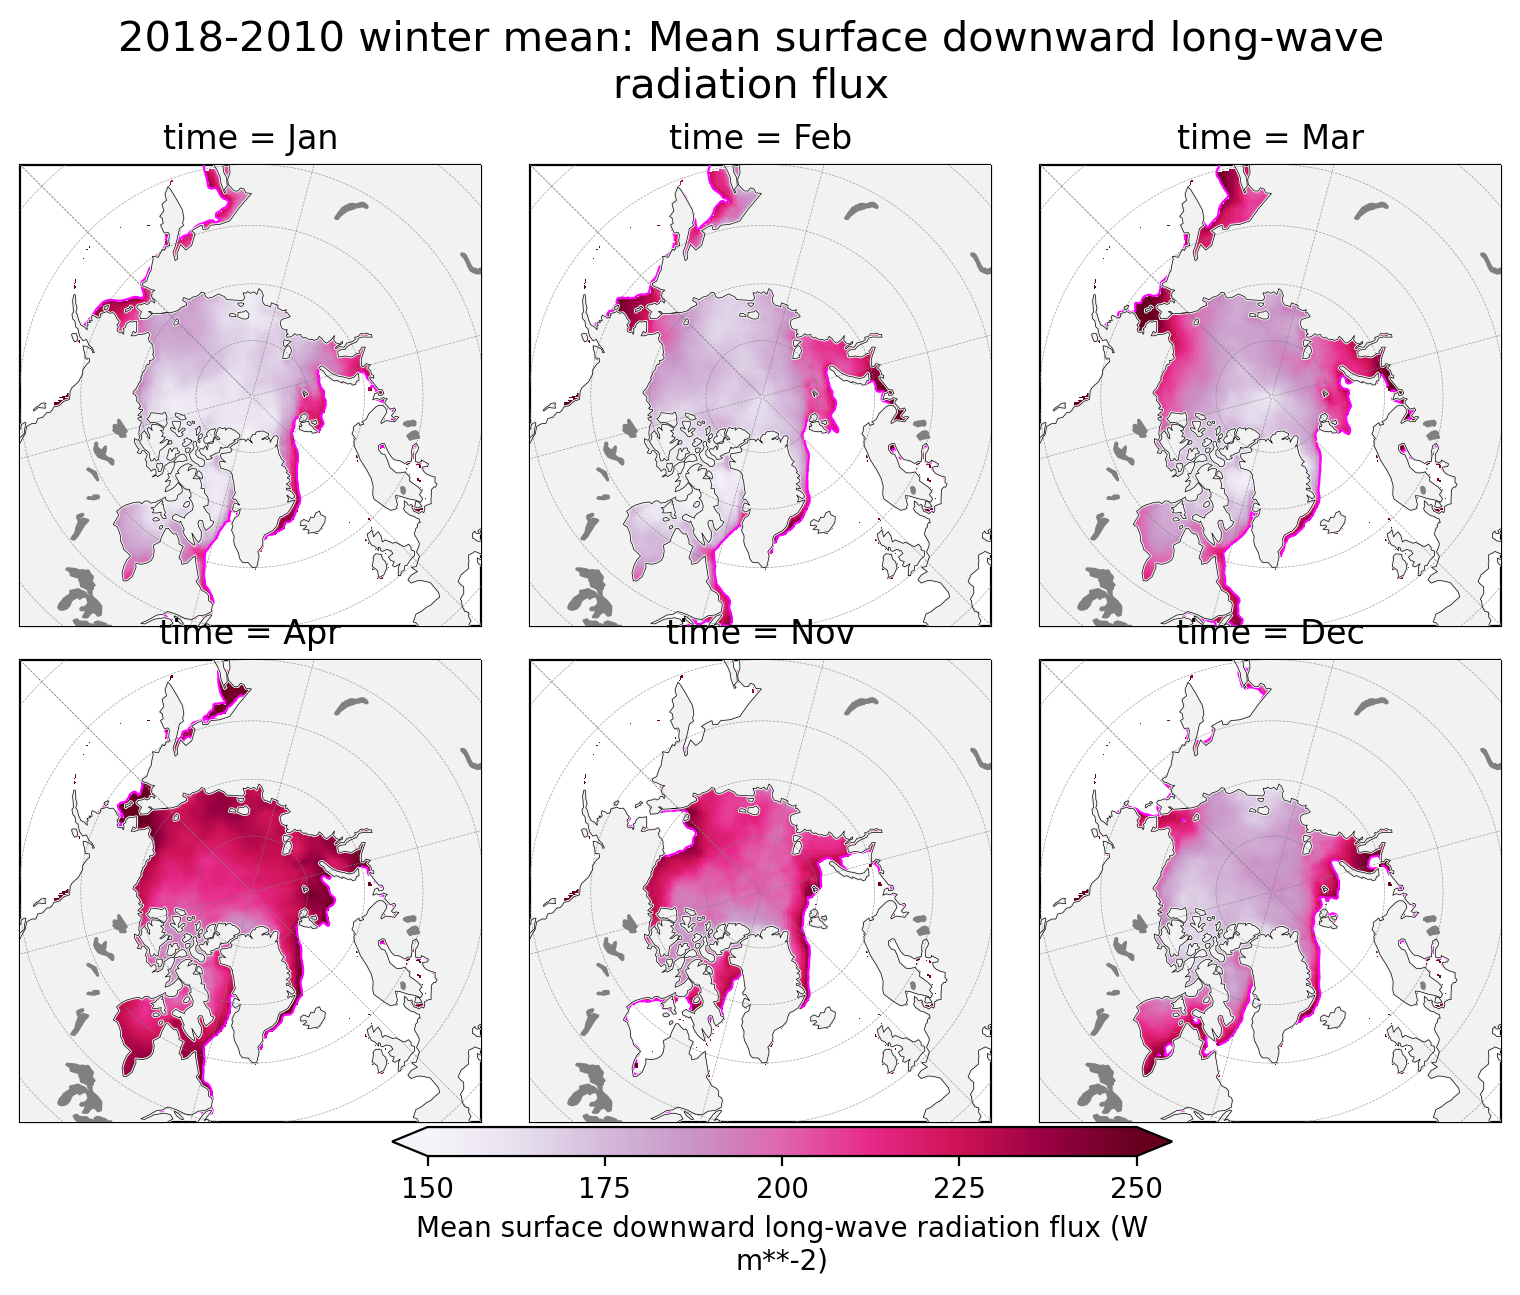

In [16]:
plotWinterMaps(winter_mean, 
               dataVar = 'msdwlwrf', 
               minval = 150, maxval = 250,
               cbarTicks = np.arange(150,250+25,25), # Set colorbar ticks for better formatting
               cmap = 'PuRd',
               title = '2018-2010 winter mean')

## NSIDC sea ice motion vectors
See the [sea ice drift](https://nicolejkeeney.github.io/icesat2-book/ice_drift.html) notebook for more information on how to plot this variable.

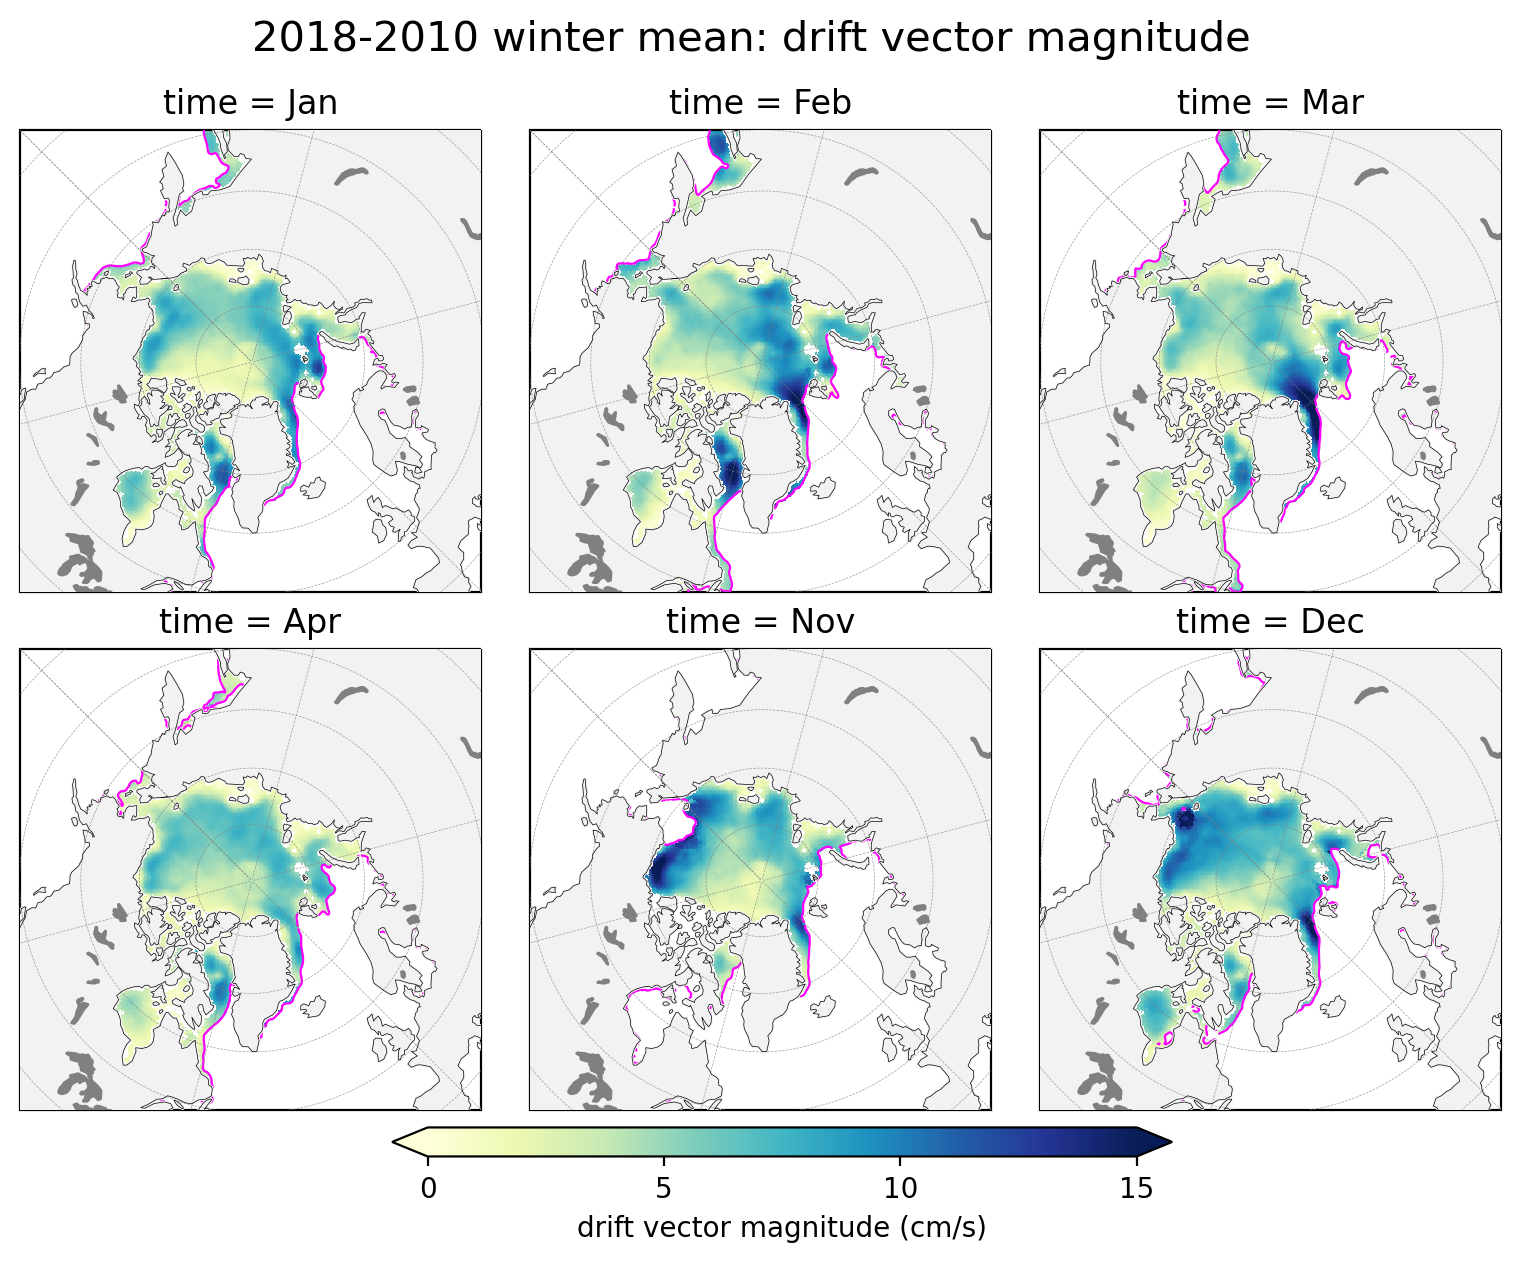

In [17]:
plotWinterMaps(winter_mean, 
               dataVar = 'drifts_magnitude', 
               minval = 0, maxval = 15,
               cbarTicks = np.arange(0,15+5,5), # Set colorbar ticks for better formatting
               cmap = 'YlGnBu',
               title = '2018-2010 winter mean')

# A note on selecting time ranges using xarray 
Xarray is a great tool to use with time series data because it is easy to restrict data to a time range or month. To restrict data to a single month, you can select that month by inputting the month as a string in a number of different ways to get the same result. 

In [18]:
time_strs = ['Jan 2019','January 2019','2019-01']
for time in time_strs:
    print(dataset.sel(time = time).time.values)

['2019-01-01T00:00:00.000000000']
['2019-01-01T00:00:00.000000000']
['2019-01-01T00:00:00.000000000']


Note how all three strings to represent January 2019 outputted the same results. <br><br>Xarray also allows you to easily select a range of data. Using the same format, you can select a slice of months representing a range of consecutive months. This is how the data was selected in the winter plotting section. 

In [19]:
print(dataset.sel(time = slice('Nov 2019', 'Apr 2020')).time.values)

['2019-11-01T00:00:00.000000000' '2019-12-01T00:00:00.000000000'
 '2020-01-01T00:00:00.000000000' '2020-02-01T00:00:00.000000000'
 '2020-03-01T00:00:00.000000000' '2020-04-01T00:00:00.000000000']


Thus giving us the corresponding date values for the months November 2019, December 2019, January 2020, February 2020, March 2020, and April 2020.